# Dataset

In [1]:
DATASET = {'20Hz_condition':[\
                              {'Control':['nm02Mar2018c0_000_ctrl.h5'],
                               'Tricine':['nm02Mar2018c0_001_tricine.h5']},
                              {'Control':['nm02Mar2018c1_000_ctrl.h5'],
                               'Tricine':['nm02Mar2018c1_002_tricine.h5']},
                              {'Control':['nm02Mar2018c2_000_ctrl.h5'],
                               'Tricine':['nm02Mar2018c2_002_tricine.h5']},
                              {'Control':['nm30Mar2018c1_000_ctrl.h5'],
                               'Tricine':['nm30Mar2018c1_004_tricine.h5']},
                              #{'Control':['nm17Apr2019c1_000.h5'],
                              # 'Tricine':['nm17Apr2019c1_001.h5']},
                            ],
           '3Hz_condition':[\
                             {'Control':['nm18Sep2019c1_000.h5'],
                              'Tricine':['nm18Sep2019c1_001.h5']},
                             {'Control':['nm19Sep2019c1_001.h5'],
                              'Tricine':['nm19Sep2019c1_002.h5']},
                             {'Control':['nm20Sep2019c1_001.h5'],
                              'Tricine':['nm20Sep2019c1_003.h5']},
                             #{'Control':['nm30Aug2019c0_000.h5'],
                             # 'Tricine':['nm30Aug2019c0_002.h5']},
                             {'Control':['nm18Sep2019c4_000.h5'],
                              'Tricine':['nm18Sep2019c4_003.h5']},
                             {'Control':['nm19Sep2019c2_001.h5'],
                              'Tricine':['nm19Sep2019c2_004.h5']},
                             {'Control':['nm23Sep2019c2_001.h5'],
                              'Tricine':['nm23Sep2019c2_002.h5']},
            ],
}


In [7]:
import os, sys
import numpy as np
from analyz.IO.igor import load_hdf5_exported_from_Igor as load_data
%matplotlib inline
from datavyz import gedn as ge

In [68]:

def abbrev_to_month(abbrev):
    M = ['January', 'February', 'March', 'April', 'May',\
         'June', 'July', 'August', 'September', 'October',\
         'November', 'December']
    for m in M:
        if (m[:3].lower()==abbrev.lower()):
            return m

        
def filename_to_path(filename):
    day, month, year = filename[2:4], filename[4:7], filename[7:11]
    cell = filename[11:13]
    cond = filename[14:17]
    return os.path.join(year, abbrev_to_month(month), filename[:13], filename)


def plot_protocol(D):
    fig, AX = ge.figure(axes_extents=[[[3,1]] for i in range(3)]+[[[3,3]]], hspace=0.3, figsize=(1,.6))
    ge.title(AX[0], D['filename'].split(os.path.sep)[-1])
    ge.plot(1e-3*D['t'], D['stimulations'][D['Vcmd_key']], ax=AX[0], axes_args={'spines':['left'], 'ylabel':'Vcmd (mV)'})
    ge.plot(1e-3*D['t'], D['stimulations'][D['stim_key']], ax=AX[1], axes_args={'spines':['left'], 'ylabel':'Stim (V)'})
    for i in range(D['recordings'][D['Irec_key']].shape[0]):
        AX[2].plot(1e-3*D['t'], D['recordings'][D['Irec_key']][i,:], color='lightgray', lw=0.3) 
    ge.plot(1e-3*D['t'], D['recordings'][D['Irec_key']].mean(axis=0), ax=AX[2],
            axes_args={'spines':['left'], 'ylabel':'raw I (nA)'})
    # now blanking the stimulus period
    cond = (D['stimulations'][D['stim_key']]>1)
    for i in range(D['recordings'][D['Irec_key']].shape[0]):
        AX[3].plot(1e-3*D['t'], D['recordings']['Irecording_clean'][i,:], color='lightgray', lw=0.3) 
    ge.plot(1e-3*D['t'], D['recordings']['Irecording_clean'].mean(axis=0), ax=AX[3],
            axes_args={'xlabel':'time (s)', 'ylabel':'Stim (V)'})

    
def LoadData(protocol,
              iexp=0, condition='Control', irec=0,
              dt_subampling=0, verbose=False):
    if sys.platform=='win32': # Windows
        root_folder = os.path.join('C:\\', 'Users', 'yann.zerlaut', 'Documents', 'DATA', 'Data_Nunzio')
    else:
        root_folder = os.path.join('/media/yann/Windows', 'Users', 'yann.zerlaut', 'Documents', 'DATA', 'Data_Nunzio')

    fn = os.path.join(root_folder, filename_to_path(DATASET[protocol][iexp][condition][irec]))
    try:
        data = load_data(fn, dt_subsampling=dt_subampling, verbose=verbose)
        data['filename'] = fn
        if 'stim' in data['stimulations']:
            data['stim_key'] = 'stim'
        else:
            data['stim_key'] = 'Stimulator'
        if 'Vcommand2' in data['stimulations']:
            data['Vcmd_key'] = 'Vcommand2'
        else:
            data['Vcmd_key'] = 'Vcommand'
        if 'Irecording2' in data['recordings']:
            data['Irec_key'] = 'Irecording2'
        else:
            data['Irec_key'] = 'Irecording'
    except (UnboundLocalError, KeyError):
        print('/!\ -- File corrupted ! -- /!\ ')
        print(fn)
        from analyz.IO.hdf5 import load_dict_from_hdf5
        data = load_dict_from_hdf5(fn)

    data = remove_stimulation_artefact(data)
        
    return data

def remove_stimulation_artefact(D, stim_threshold=1.):
    # now blanking the stimulus period
    cond = (np.abs(D['stimulations'][D['stim_key']])>stim_threshold)
    D['recordings']['Irecording_clean'] = 1.*D['recordings'][D['Irec_key']]
    for i in range(D['recordings'][D['Irec_key']].shape[0]):
        D['recordings']['Irecording_clean'][i,:][cond] = D['recordings'][D['Irec_key']][i,:][-1]
    return D

data = LoadData('3Hz_condition', iexp=5, condition='Control')
data = remove_stimulation_artefact(data)

In [69]:
data = LoadData('3Hz_condition', iexp=5, condition='Control')
data['recordings']

{'Irecording2': array([[0.79185848, 0.79572249, 0.80151852, ..., 0.79636649, 0.79314648,
         0.79121447],
        [0.79314648, 0.79057047, 0.78992647, ..., 0.77897842, 0.77833442,
         0.77511441],
        [0.7718944 , 0.7718944 , 0.77447041, ..., 0.78284244, 0.78735046,
         0.78541845],
        ...,
        [0.67142999, 0.673362  , 0.66949798, ..., 0.67593801, 0.66885398,
         0.66885398],
        [0.66112595, 0.66305796, 0.66756598, ..., 0.65661793, 0.65661793,
         0.66305796],
        [0.68817406, 0.69075007, 0.69525809, ..., 0.67851402, 0.67722602,
         0.67593801]]),
 'Irecording_clean': array([[0.79185848, 0.79572249, 0.80151852, ..., 0.79636649, 0.79314648,
         0.79121447],
        [0.79314648, 0.79057047, 0.78992647, ..., 0.77897842, 0.77833442,
         0.77511441],
        [0.7718944 , 0.7718944 , 0.77447041, ..., 0.78284244, 0.78735046,
         0.78541845],
        ...,
        [0.67142999, 0.673362  , 0.66949798, ..., 0.67593801, 0.66885398,

- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording2 in nA
- Stimulation channels:
  * 0) Vcommand2 in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording2 in nA
- Stimulation channels:
  * 0) Vcommand2 in mV
  * 1) Stimulator in V


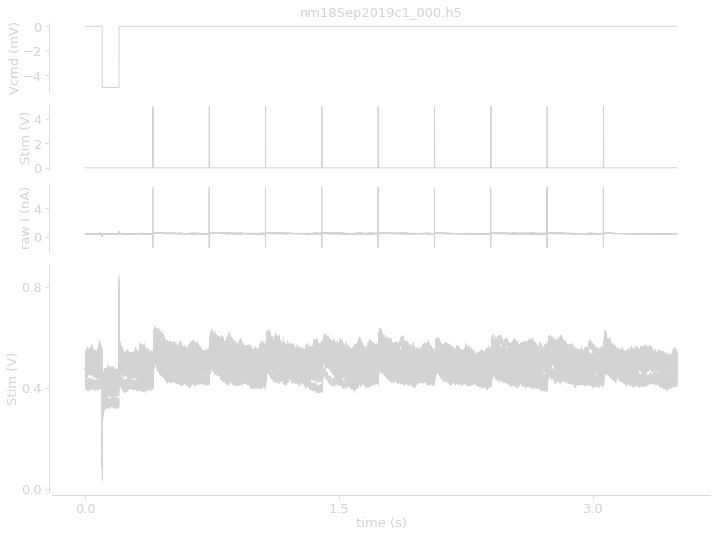

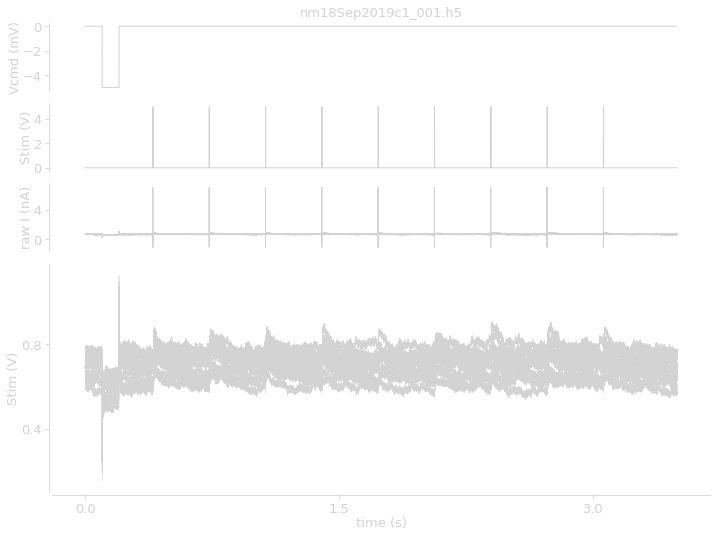

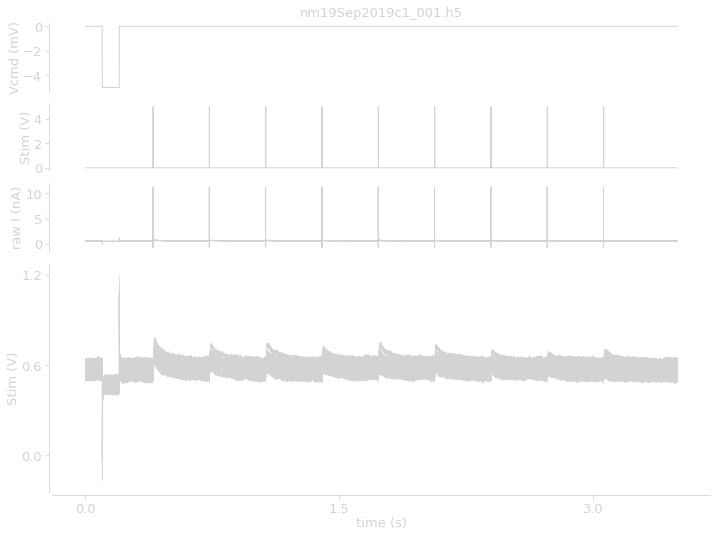

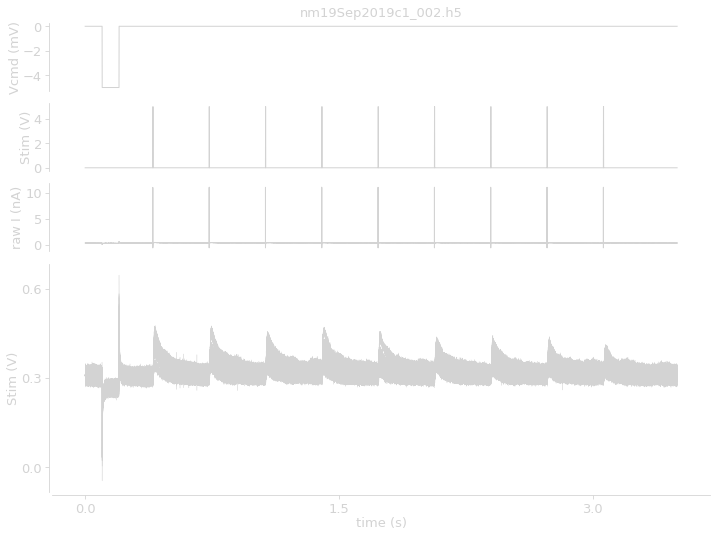

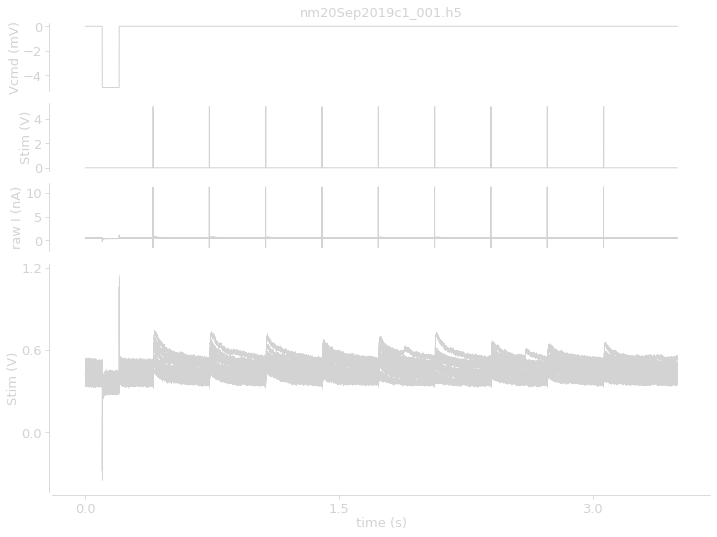

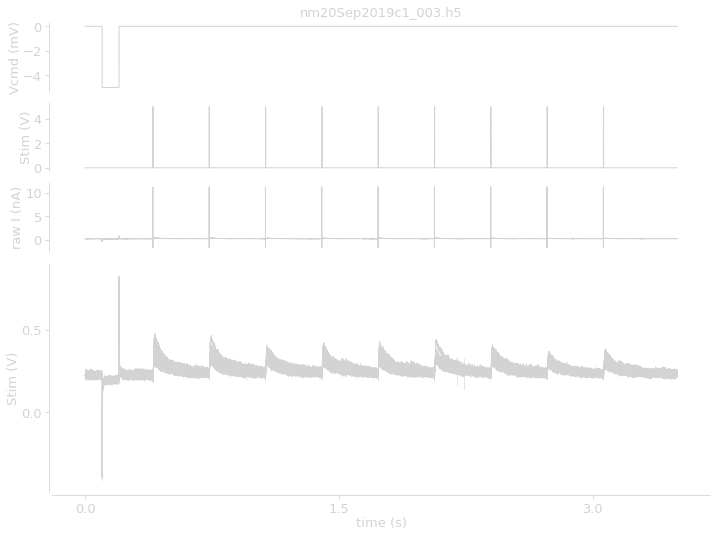

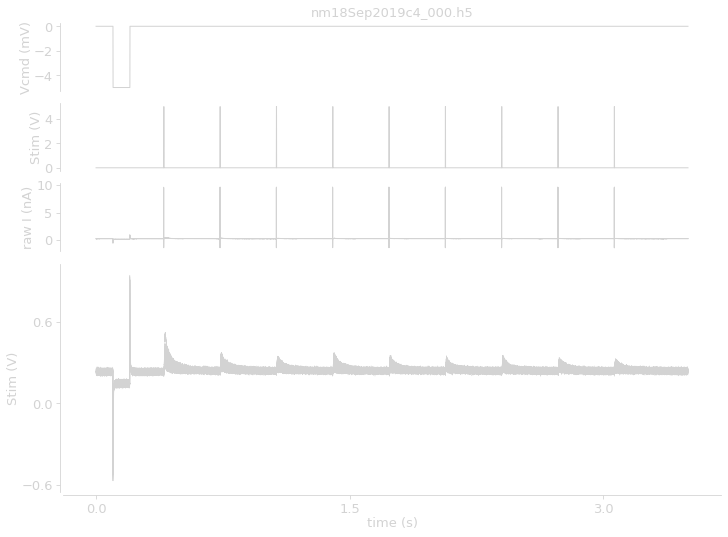

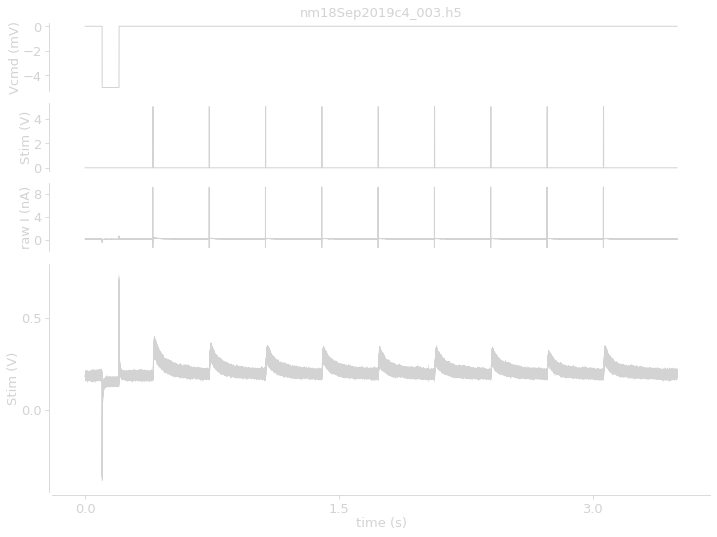

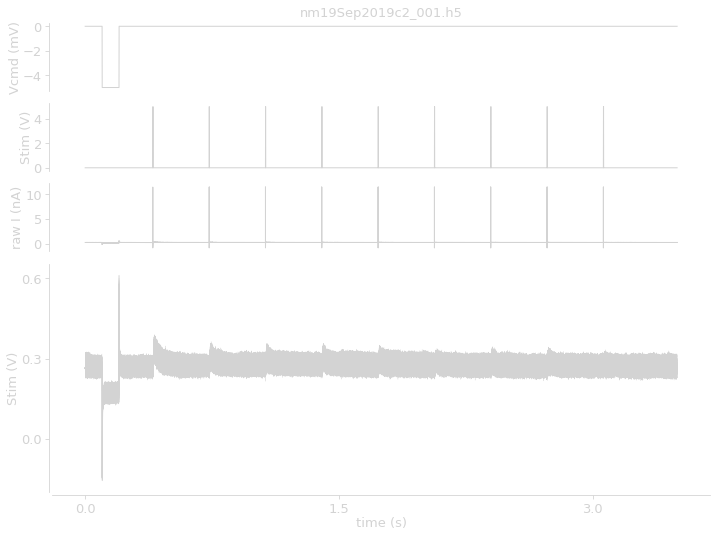

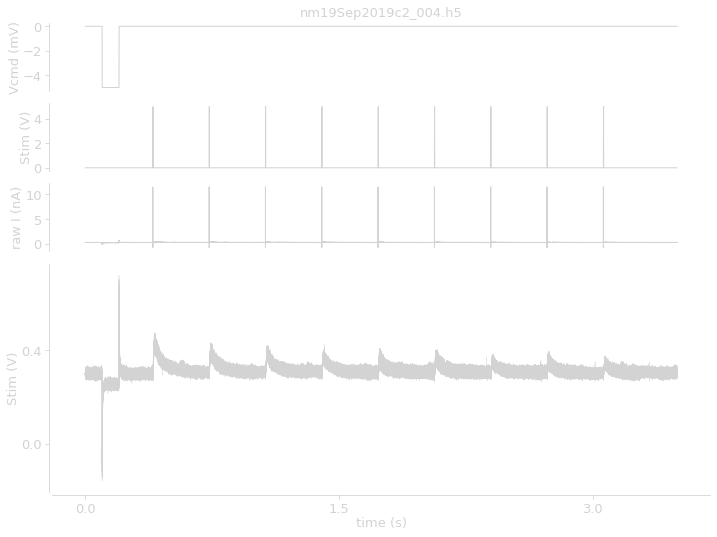

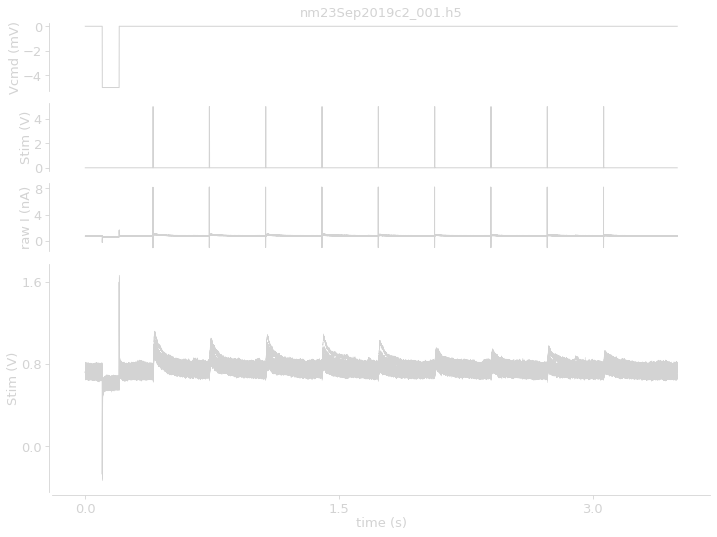

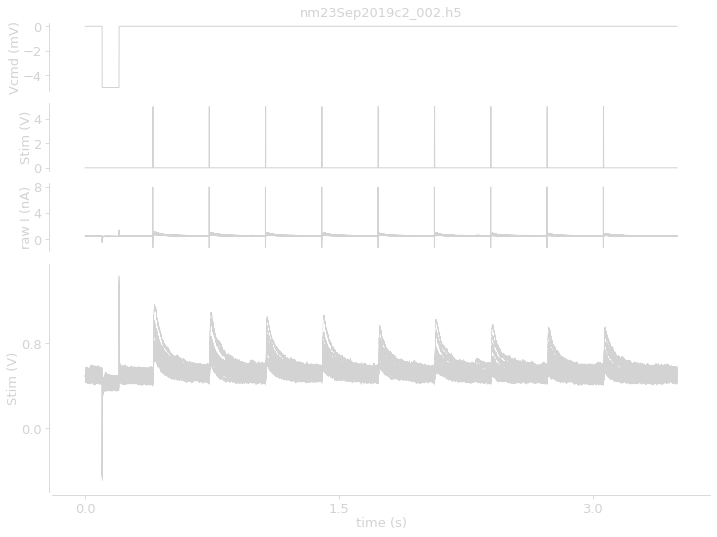

In [9]:
cond = '3Hz_condition'
for i, cell in enumerate(DATASET[cond]):
    data_ctrl = LoadData(cond, iexp=i, condition='Control')
    plot_protocol(data_ctrl)
    data_test = LoadData(cond, iexp=i, condition='Tricine')
    plot_protocol(data_test)

In [70]:
def compute_norm_trace(data,
                       window_for_peak=20, # ms
                       pre_window = 150, # ms
                       t0=400,
                       with_all=False):

    tcond = (data['t']>t0-pre_window)
    baseline_cond = (data['t']>t0-pre_window) & (data['t']<t0)
    baseline = data['recordings']['Irecording_clean'].mean(axis=0)[baseline_cond].mean()
    trace = data['recordings']['Irecording_clean'].mean(axis=0)[tcond]-baseline
        
    peak_cond = (data['t'][tcond]>t0) & (data['t'][tcond]<t0+window_for_peak)
    norm_trace = trace/np.max(trace[peak_cond])

    if with_all:
        return data['t'][tcond], norm_trace, np.max(trace[peak_cond])
    else:
        return norm_trace

    
def protocol_comparison(DATA,
                        labels=['Control', 'Tricine'],
                        colors=['k', ge.green],
                        window_for_peak=20, # ms
                        pre_window = 150, # ms
                        t0=400):
    fig, AX = ge.figure(axes=(1,3), figsize=(2,1.3), hspace=0.3)
    for data, c in zip(DATA, colors):
        AX[0].plot(1e-3*data['t'], data['recordings'][data['Irec_key']].mean(axis=0), color=c)
    ge.set_plot(AX[0], ['left'], ylabel='raw-I (nA)')

    for data, label, c in zip(DATA, labels, colors):
        tcond = (data['t']>t0-pre_window)
        baseline_cond = (data['t']>t0-pre_window) & (data['t']<t0)
        baseline = data['recordings']['Irecording_clean'].mean(axis=0)[baseline_cond].mean()
        trace = data['recordings']['Irecording_clean'].mean(axis=0)[tcond]-baseline
        
        peak_cond = (data['t'][tcond]>t0) & (data['t'][tcond]<t0+window_for_peak)
        norm_trace = compute_norm_trace(data, window_for_peak, pre_window, t0)
        
        AX[1].plot(1e-3*data['t'][tcond], trace, color=c, label=label)
        AX[2].plot(1e-3*data['t'][tcond], norm_trace, color=c, label=label)
        
    ge.set_plot(AX[1], ['left'], ylabel='I (nA)\n (-baseline&stim)')
    ge.set_plot(AX[2], xlabel='time (s)', ylabel='I (nA)\n (-baseline&stim)\n (+rescaled)')
    
    ge.legend(AX[1])
    return fig, AX


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V
- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V
- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V
- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V
- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V
- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording2 in nA
- Stimulation channels:
  * 0) Vcommand2 in mV
  * 1) Stimulator in V
- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording2 in nA
- Stimulation channels:
  * 0) Vcommand2 in mV
  * 1) Stimulator in V


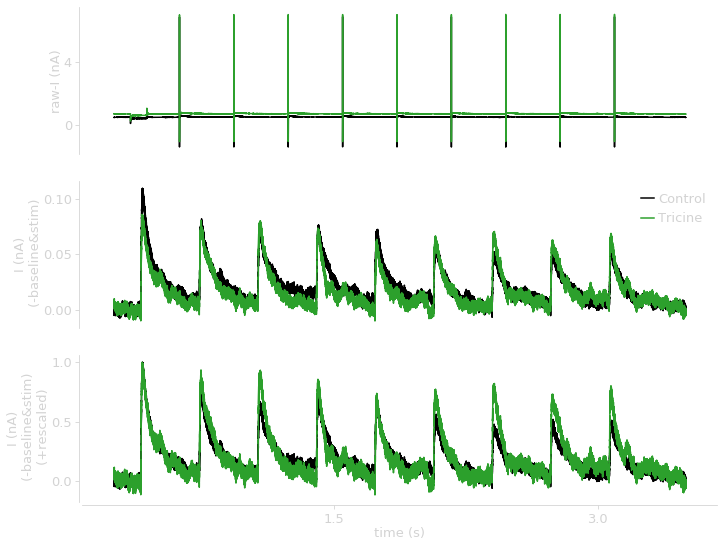

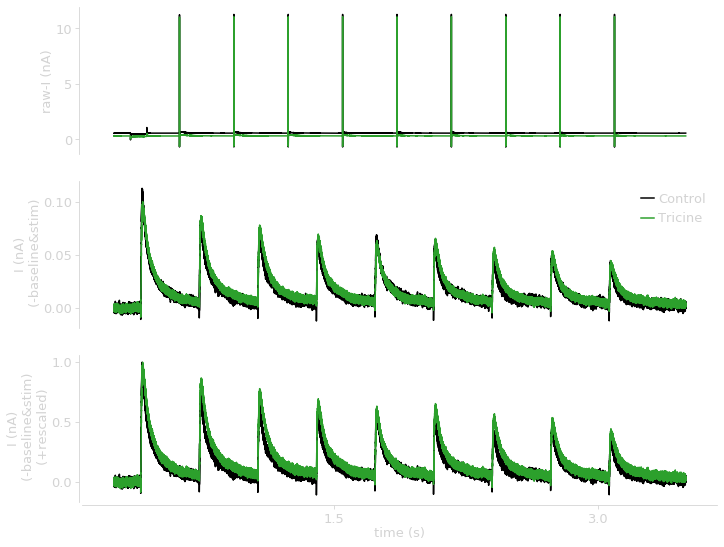

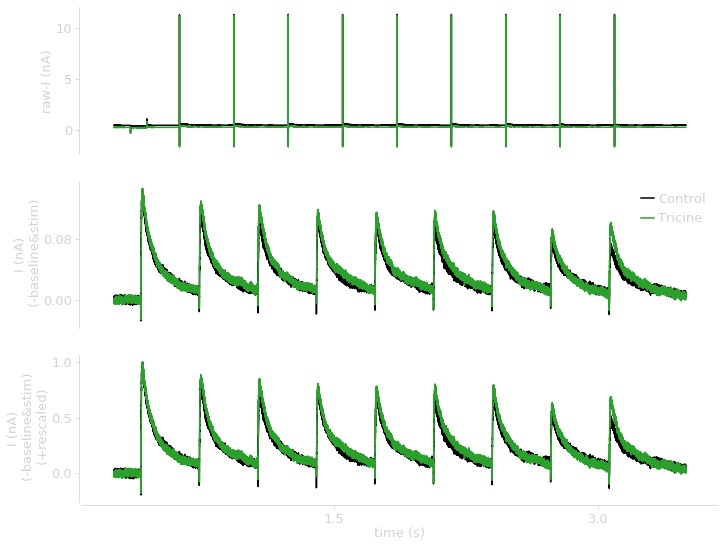

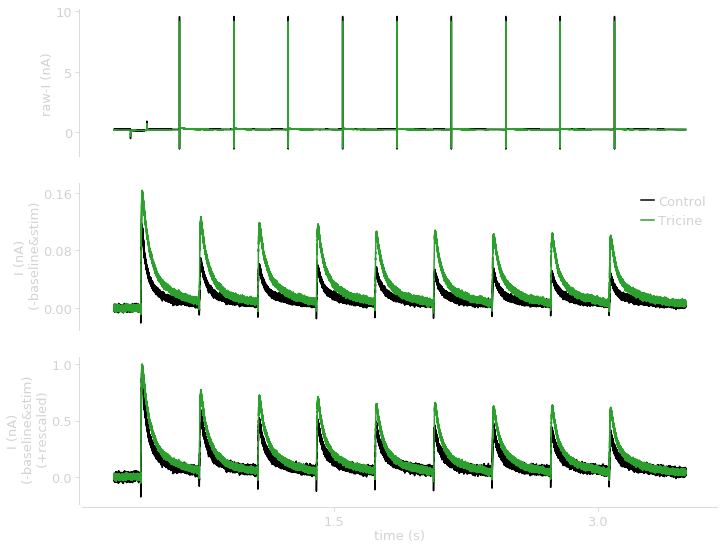

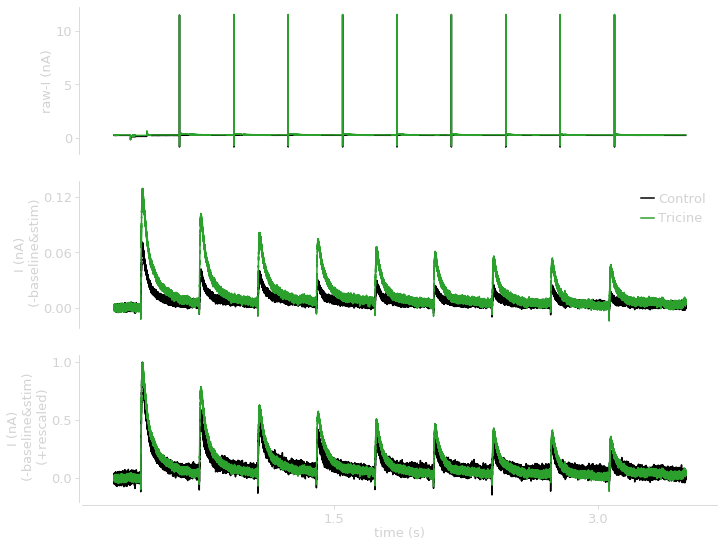

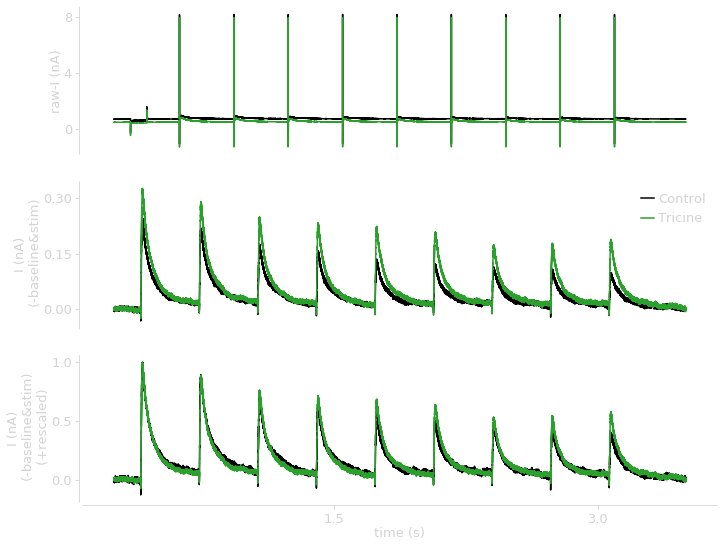

In [13]:
cond = '3Hz_condition'
for i, cell in enumerate(DATASET[cond]):
    data_ctrl = LoadData(cond, iexp=i, condition='Control')
    data_test = LoadData(cond, iexp=i, condition='Tricine')
    protocol_comparison([data_ctrl, data_test])

- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V
- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V
- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V
- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V
- temporal sampling, original time step: 0.010ms
    --> subsampled at 0.010ms
- Recordings channels:
  * 0) Irecording in nA
- Stimulation channels:
  * 0) Vcommand in mV
  * 1) Stimulator in V


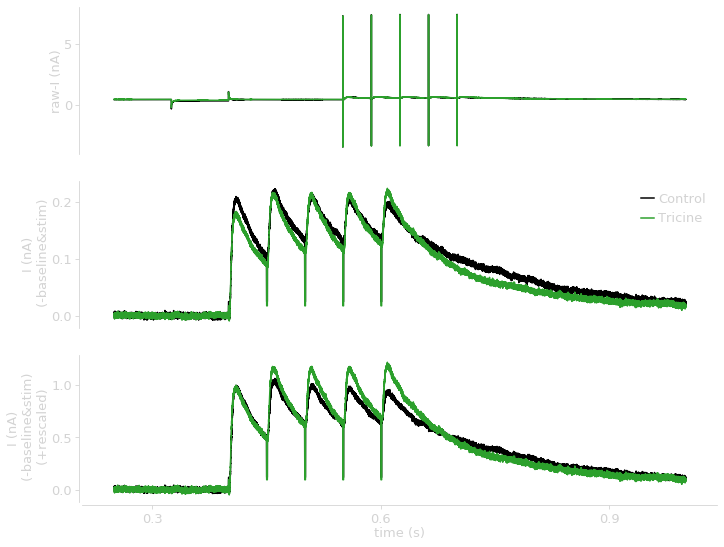

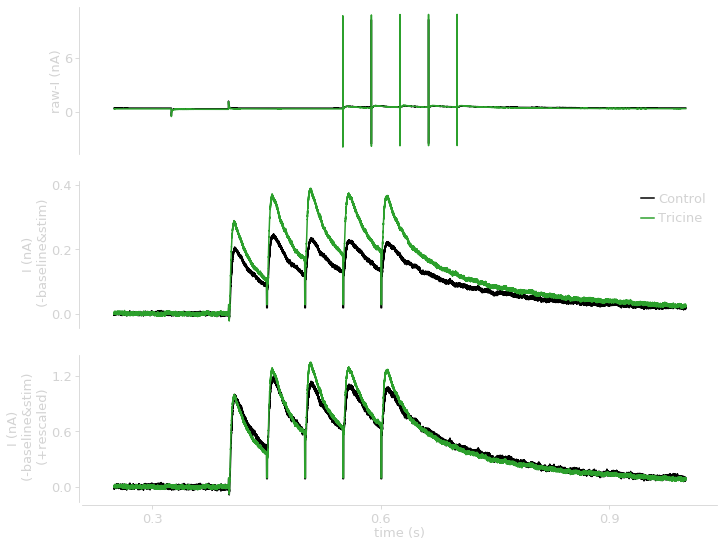

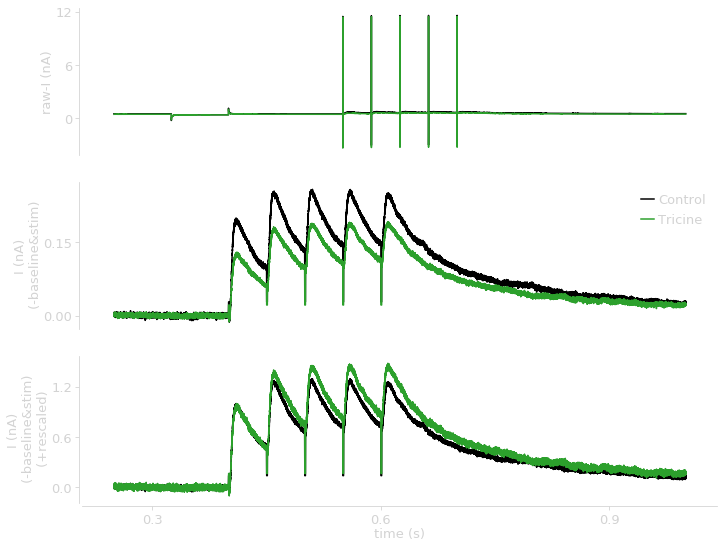

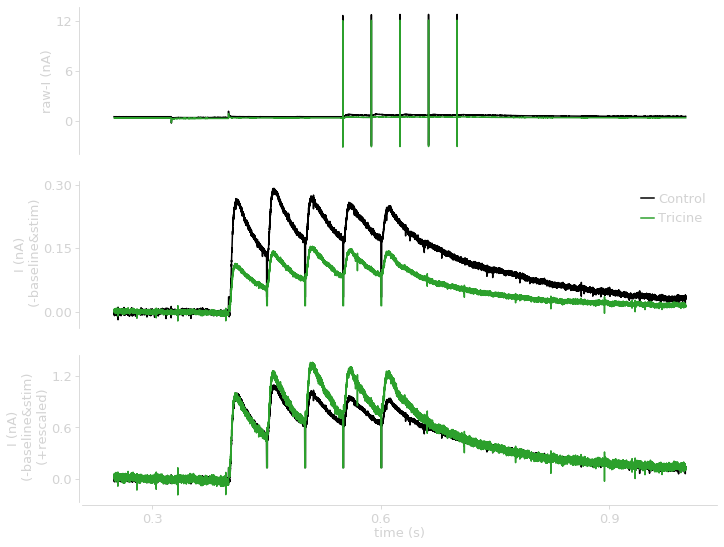

In [14]:
cond = '20Hz_condition'
for i, cell in enumerate(DATASET[cond]):
    data_ctrl = LoadData(cond, iexp=i, condition='Control')
    data_test = LoadData(cond, iexp=i, condition='Tricine')
    protocol_comparison([data_ctrl, data_test])

In [71]:
cond = '3Hz_condition'
norm_trace_ctrl, norm_trace_test = [], []
for i, cell in enumerate(DATASET[cond]):
    data_ctrl = LoadData(cond, iexp=i, condition='Control')
    norm_trace_ctrl.append(compute_norm_trace(data_ctrl,
                                              window_for_peak=20,
                                              pre_window = 150,
                                              t0=400))
    data_test = LoadData(cond, iexp=i, condition='Tricine')
    norm_trace_test.append(compute_norm_trace(data_test,
                                              window_for_peak=20,
                                              pre_window = 150,
                                              t0=400))


(None, <matplotlib.axes._subplots.AxesSubplot at 0x7fb6ac991250>)

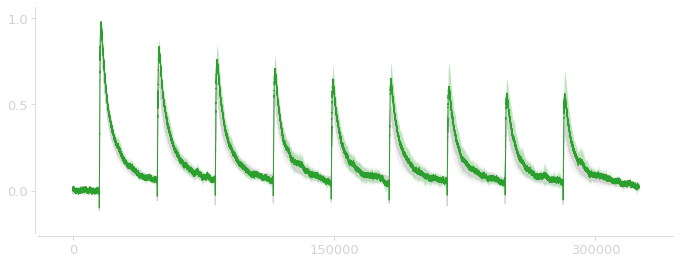

In [24]:
fig, ax = ge.figure(figsize=(2,2))
ge.plot(np.mean(norm_trace_ctrl, axis=0), sy=np.std(norm_trace_ctrl, axis=0), ax=ax)
ge.plot(np.mean(norm_trace_test, axis=0), sy=np.std(norm_trace_test, axis=0), ax=ax, color=ge.green)

In [75]:
cond = '3Hz_condition'
norm_trace_ctrl, norm_trace_test = [], []
scale_ctrl, scale_test = [], []
for i, cell in enumerate(DATASET[cond]):
    data_ctrl = LoadData(cond, iexp=i, condition='Control')
    t, n_trace, scale = compute_norm_trace(data_ctrl,
                                        window_for_peak=20,
                                        pre_window = 150,
                                        t0=400, with_all=True)
    norm_trace_ctrl.append(n_trace)
    scale_ctrl.append(scale)
    data_test = LoadData(cond, iexp=i, condition='Tricine')
    t, n_trace, scale = compute_norm_trace(data_test,
                                        window_for_peak=20,
                                        pre_window = 150,
                                        t0=400, with_all=True)
    norm_trace_test.append(n_trace)
    scale_test.append(scale)


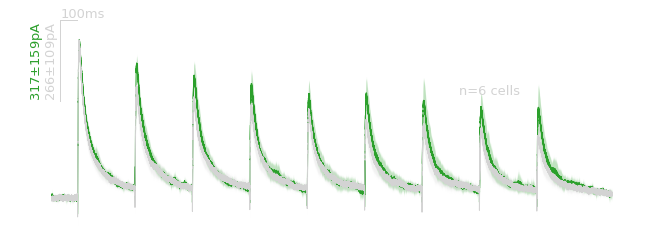

In [77]:
fig, ax = ge.figure(figsize=(2,2))
t0, I0 = t[0]+50, 1.1
T, DI = 100, 0.5
ax.plot([t0, t0], [I0,I0-DI], lw=1, color=ge.default_color)
ax.plot([t0, t0+T], [I0, I0], lw=1, color=ge.default_color)
ge.annotate(ax, '%.0f$\pm$%.0fpA' % (1e3*np.mean(scale_ctrl)/DI, 1e3*np.std(scale_ctrl)/DI),
            (t0, I0-DI), xycoords='data', rotation=90, ha='right')
ge.annotate(ax, '%.0f$\pm$%.0fpA\n' % (1e3*np.mean(scale_test)/DI, 1e3*np.std(scale_test)/DI),
            (t0, I0-DI), xycoords='data', rotation=90, color=ge.green, ha='right')
ge.plot(t, np.mean(norm_trace_test, axis=0), sy=np.std(norm_trace_test, axis=0), ax=ax, color=ge.green)
ge.plot(t, np.mean(norm_trace_ctrl, axis=0), sy=np.std(norm_trace_ctrl, axis=0), ax=ax)
ge.annotate(ax, 'n=%i cells' % len(scale_ctrl), (.7,.6))
ge.annotate(ax, '%ims' % T, (t0, I0), xycoords='data')
ge.set_plot(ax,[])